In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/google_drive', force_remount=True)
!unlink /content/drive
!ln -s /content/google_drive/MyDrive/ /content/drive

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/google_drive
unlink: cannot unlink '/content/drive': No such file or directory


In [ ]:
!nvidia-smi

**Starting Work**

In [2]:
from os import chdir, environ
environ['TZ'] = 'US/Central'

In [3]:
cd /content/drive/PointCloud/

/content/google_drive/MyDrive/PointCloud


In [4]:
!ls -lt --time-style='+%y-%m-%d %H:%M:%S'

total 1448
-rw------- 1 root root   10797 21-10-05 20:43:00 model_attention.py
-rw------- 1 root root    8955 21-10-05 09:45:55 model.py
-rw------- 1 root root   12997 21-10-03 13:11:15 build_tree.py
-rw------- 1 root root    2769 21-10-02 02:19:14 build_tree_basic.cpp
-rw------- 1 root root    3726 21-10-02 02:03:01 build_tree.cpp
-rw------- 1 root root    7892 21-09-30 22:17:09 model_channel.py
drwx------ 2 root root    4096 21-09-24 10:52:59 old
drwx------ 2 root root    4096 21-09-23 21:10:48 __pycache__
drwx------ 2 root root    4096 21-09-23 18:24:21 datasets
drwx------ 2 root root    4096 21-09-23 16:54:41 scratch
-rw------- 1 root root     208 21-09-23 16:54:38 def.sh
-rw------- 1 root root 1416550 21-09-23 16:54:35 dev.out


**Experiment Init**

In [5]:
import json
import h5py
import torch
import os
# from model import Encoder, init_logging
from model_attention import Encoder, init_logging
from build_tree import get_directions, init_directions
import logging

In [6]:
OUTPUT = 'scratch'
model_size = 2 ** 11
channel = 4
dim = 512
basic = False
tree_arrange_rotate = False
prefix = "_basic" if basic else ""
sample_layers = 2
num_classes = 40
DATASET = './datasets/ModelNet40'
chaos_limit = 3 if not basic else 1
init_logging(OUTPUT)
_ = init_directions(chaos_limit)

2021-10-05 20:44:09 - INFO:	init_directions: # = 13
2021-10-05 20:44:10 - DEBUG:	0: tensor([0., 0., 1.], device='cuda:0') otho = {8, 2, 11, 5}
2021-10-05 20:44:10 - DEBUG:	1: tensor([ 0.0000,  0.7071, -0.7071], device='cuda:0') otho = {8, 3, 4, 12}
2021-10-05 20:44:10 - DEBUG:	2: tensor([0., 1., 0.], device='cuda:0') otho = {0, 8, 9, 7}
2021-10-05 20:44:10 - DEBUG:	3: tensor([0.0000, 0.7071, 0.7071], device='cuda:0') otho = {8, 1, 10, 6}
2021-10-05 20:44:10 - DEBUG:	4: tensor([ 0.5774, -0.5774, -0.5774], device='cuda:0') otho = {1, 11, 9}
2021-10-05 20:44:10 - DEBUG:	5: tensor([ 0.7071, -0.7071,  0.0000], device='cuda:0') otho = {0, 10, 11, 12}
2021-10-05 20:44:10 - DEBUG:	6: tensor([ 0.5774, -0.5774,  0.5774], device='cuda:0') otho = {11, 3, 7}
2021-10-05 20:44:10 - DEBUG:	7: tensor([ 0.7071,  0.0000, -0.7071], device='cuda:0') otho = {9, 2, 12, 6}
2021-10-05 20:44:10 - DEBUG:	8: tensor([1., 0., 0.], device='cuda:0') otho = {0, 1, 2, 3}
2021-10-05 20:44:10 - DEBUG:	9: tensor([0.7071, 

In [7]:
model = Encoder(model_size, sample_layers, dim, OUTPUT, channel=channel).cuda()
linear = torch.nn.Linear(channel * dim, num_classes).cuda()

2021-10-05 20:44:12 - INFO:	self.N = 2048
2021-10-05 20:44:12 - INFO:	self.num_layers = 12
2021-10-05 20:44:12 - INFO:	self.sample_layers = 2
2021-10-05 20:44:12 - INFO:	layer 11 (leaf) # = 13860 dim = 8 relu_weight = 0.32
2021-10-05 20:44:12 - INFO:	layer 10 (unsampled) # = 5741 dim = 16 relu_weight = 0.31
2021-10-05 20:44:12 - INFO:	layer 9 (sampled) # = 2378 dim = 16 relu_weight = 0.3
2021-10-05 20:44:12 - INFO:	layer 8 (sampled) # = 985 dim = 32 relu_weight = 0.29
2021-10-05 20:44:12 - INFO:	layer 7 (sampled) # = 408 dim = 32 relu_weight = 0.27999999999999997
2021-10-05 20:44:12 - INFO:	layer 6 (sampled) # = 169 dim = 64 relu_weight = 0.26999999999999996
2021-10-05 20:44:12 - INFO:	layer 5 (sampled) # = 70 dim = 64 relu_weight = 0.25999999999999995
2021-10-05 20:44:12 - INFO:	layer 4 (sampled) # = 29 dim = 128 relu_weight = 0.24999999999999994
2021-10-05 20:44:12 - INFO:	layer 3 (sampled) # = 12 dim = 128 relu_weight = 0.23999999999999994
2021-10-05 20:44:12 - INFO:	layer 2 (sample

**Debug**

In [ ]:
pts = h5py.File(f'{DATASET}/train0.h5')['data'][11]
pts = torch.tensor(pts).cuda()
output = None

In [ ]:
# Random rotate
if True:
    pts = pts.cuda()
    from random import uniform
    from math import acos, cos, sin
    pi = acos(-1)
    ox = uniform(0, 2 * pi)
    oy = uniform(0, 2 * pi)
    oz = uniform(0, 2 * pi)
    ox = torch.tensor([
        [1, 0, 0],
        [0, cos(ox), -sin(ox)],
        [0, sin(ox), cos(ox)]
    ]).float().cuda()
    oy = torch.tensor([
        [cos(oy), 0, -sin(oy)],
        [0, 1, 0],
        [sin(oy), 0, cos(oy)],
    ]).float().cuda()
    oz = torch.tensor([
        [cos(oz), -sin(oz), 0],
        [sin(oz), cos(oz), 0],
        [0, 0, 1]
    ]).float().cuda()
    bias = torch.randn_like(pts) * 1e-8
    pts = pts.matmul(ox).matmul(oy).matmul(oz) + bias
    output = None

In [ ]:
tree = model.tree
pts, output, arrange = tree.arrange(pts, basic=basic, rotate=tree_arrange_rotate, debug=True, vec_per_point=4)

In [ ]:
def see_metric(vpp, axis=[0, 0, 1], window_size=1):
    d = (pts * torch.tensor(axis).to(pts.device)).sum(dim=-1)
    scale = (d[-1] - d[0]).detach()
    d = (d[window_size:] - d[:-window_size]) / scale
    print(-(d - d.mean()).tanh().mean().item())

    points = pts.cuda()
    n = pts.size(0)
    allvec = (points - points[:, None])
    _, ind = allvec.norm(dim=-1).topk(1 + vpp, dim=-1, largest=False)
    ind = ind[:, 1 :]
    ind = torch.stack([ind] * 3, dim=-1)
    vec = allvec.gather(1, ind)
    vec = vec / vec.norm(dim=-1, keepdim=True)

    dotprod = vec * torch.tensor(axis).cuda()
    dotprod = dotprod.sum(dim=-1).abs()
    mark = dotprod.min(1 - dotprod)
    print(mark.mean().item())
see_metric(4, [0, 0, 1])

0.00427117059007287
0.17858152091503143


In [ ]:
%matplotlib inline
def plot(points, color_layers=2, output=None):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.gridspec as gridspec
    import numpy as np

    points = points.cpu().numpy()
    x, y, z = points[:,0], points[:,1], points[:,2]

    color = np.array([0 for _ in range(x.shape[0])])
    
    def mark_color(z, last_ind=None):
        n = z.shape[0]
        ind = torch.tensor(z).sort()[1].numpy()
        indl, indr = ind[: n >> 1], ind[n >> 1 : ]
        if last_ind is not None:
            indl, indr = last_ind[indl], last_ind[indr]
        color[indr] += 1
        return indl, indr

    if output is not None:

        color = torch.tensor([0]).cuda()
        # print(tree.layer_size)
        for i, (layer, next_layer_size) in enumerate(zip(reversed(model.layers[1:]), tree.layer_size[1:])):
            next_color = torch.zeros(next_layer_size).long().cuda()
            if i < color_layers:
                color = color << 1
                right_add = 1
            else:
                right_add = 0
            assert layer.child_l.max() < next_layer_size
            assert layer.child_r.max() < next_layer_size
            next_color[layer.child_l] = color
            next_color[layer.child_r] = color + right_add
            color = next_color

        arrange = output[0]
        n = points.shape[0]
        color = np.array([color[arrange == i].max().item() for i in range(n)])

    elif color_layers >= 1:
        l, r = mark_color(z)
        if color_layers >= 2:
            color *= 2
            ll, lr = mark_color(y[l], l)
            rl, rr = mark_color(y[r], r)
            if color_layers >= 3:
                color *= 2
                for p in [ll, lr, rl, rr]:
                    mark_color(x[p], p)

    colormap = np.array(['red', 'blue', 'green', 'yellow', 'grey', 'orange', 'purple', 'cyan'])

    fig = plt.figure(dpi=80)
    gs = gridspec.GridSpec(nrows=2, ncols=4, left=0.1, right=2.5, wspace=0.05, hspace=0.05, bottom=0.1, top=1.3)
    for i in range(8):
        ax = fig.add_subplot(gs[i // 4, i % 4], projection='3d')

        x, y, z = points[:,0], points[:,1], points[:,2]
        labx, laby, labz = 'x', 'y', 'z'
        if (i & 4) != 0:    x = -x; labx = '-x'
        if (i & 2) != 0:    y = -y; laby = '-y'
        if (i & 1) != 0:    z = -z; labz = '-z'

        lmin = min(x.min(), y.min(), z.min())
        lmax = max(x.max(), y.max(), z.max())
        ax.scatter(x, y, z, c=colormap[color], marker='.')

        ax.set_xlim(lmin, lmax)
        ax.set_ylim(lmin, lmax)
        ax.set_zlim(lmin, lmax)

        ax.set_xlabel(labx)
        ax.set_ylabel(laby)
        ax.set_zlabel(labz) 
    plt.show()

    fig = plt.figure(dpi=80)
    ncolor = color.max() + 1
    nrows = max(1, ncolor // 4)
    ncols = min(ncolor, 4)
    gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, left=0.1, right=0.1 + 0.6 * ncols, wspace=0.05, hspace=0.05, bottom=0.1, top=0.1 + 0.6 * nrows)
    for i in range(ncolor):
        ax = fig.add_subplot(gs[i // 4, i % 4], projection='3d')

        p = points[color == i]
        x, y, z = p[:,0], p[:,1], p[:,2]

        lmin = min(x.min(), y.min(), z.min())
        lmax = max(x.max(), y.max(), z.max())
        ax.scatter(x, y, z, c=colormap[i], marker='.')

        ax.set_xlim(lmin, lmax)
        ax.set_ylim(lmin, lmax)
        ax.set_zlim(lmin, lmax)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z') 
    plt.show()

2021-10-05 20:29:37 - DEBUG:	Loaded backend module://ipykernel.pylab.backend_inline version unknown.


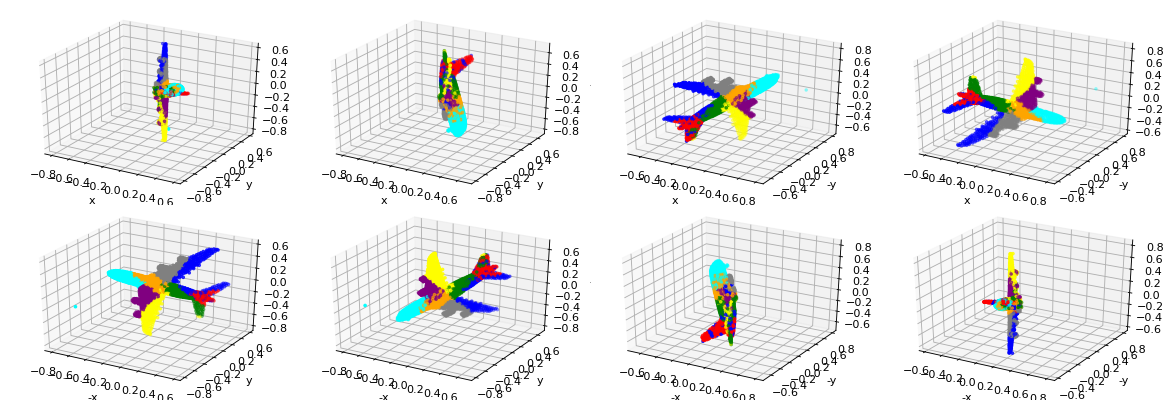

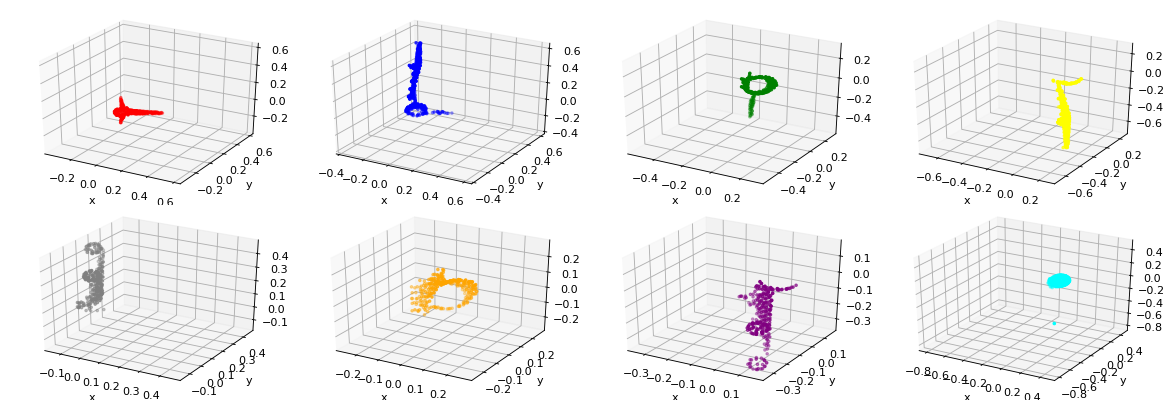

In [ ]:
plot(pts, 3, output=output)

In [ ]:
for i in range(50):
    output, arrange = tree.arrange(pts, basic=basic, debug=False, device='cpu')

In [ ]:
output = list(map(lambda x : x.unsqueeze(0), output))
output[0] = pts[output[0]]
feature = model(output, perm=5)

In [ ]:
feature.sum().backward()

In [ ]:
for i in range(10):
    loss = model(output).view(-1).sum()
    loss.backward()

In [ ]:
opt.zero_grad()

In [ ]:
for name, param in model.named_parameters():
    print(name, param.size())

In [ ]:
for name, param in model.named_parameters():
    if 'activate' in name:
        print(name, "\t", param.item())

In [ ]:
!cp /tmp/cppinput.txt scratch/

In [ ]:
!tail -n 5 /tmp/cppoutput.txt

**Data**

In [ ]:
!mkdir scratch/archive_211001_basic
!mv scratch/*_data.pth scratch/archive_211001_basic/
!rm -rf scratch/*.pth

mkdir: cannot create directory ‘scratch/archive_211001_basic’: File exists


In [ ]:
from random import uniform
from math import acos, cos, sin
pi = acos(-1)

def get_random_transform():
    ox = uniform(0, 2 * pi)
    oy = uniform(0, 2 * pi)
    oz = uniform(0, 2 * pi)
    ox = torch.tensor([
        [1, 0, 0],
        [0, cos(ox), -sin(ox)],
        [0, sin(ox), cos(ox)]
    ]).float().cuda()
    oy = torch.tensor([
        [cos(oy), 0, -sin(oy)],
        [0, 1, 0],
        [sin(oy), 0, cos(oy)],
    ]).float().cuda()
    oz = torch.tensor([
        [cos(oz), -sin(oz), 0],
        [sin(oz), cos(oz), 0],
        [0, 0, 1]
    ]).float().cuda()
    axisperm = torch.randperm(3).cuda()
    axissgn = torch.tensor(-1).pow(torch.randint(low=0, high=2, size=[3])).cuda()

    return lambda points : (points.matmul(ox).matmul(oy).matmul(oz) + torch.randn_like(points) * 1e-8)[:, axisperm] * axissgn

def make_data(points, label, transform=lambda x : x, basic_arrange=basic, debug=False):
    points = transform(torch.tensor(points).cuda())
    label = torch.tensor(label).squeeze().cuda().long()
    points, output, arrange = model.tree.arrange(points, basic=basic_arrange, rotate=tree_arrange_rotate, debug=debug)

    for j, val in enumerate(output):
        vmax = val.max().item()
        if vmax < 128:
            output[j] = val.char().cpu()
        else:
            assert vmax < 65536
            output[j] = val.short().cpu()

    assert arrange.max().item() < 65536
    points = points.cpu()
    label = label.cpu()
    arrange = arrange.short().cpu()

    assert 0 <= label.item() < num_classes
    return (points, output, arrange, label)

def process_data(data, source, save, basic_arrange=basic, transform=lambda x : x, debug=False):
    logging.info(f"Process data in {source} save in {save}")
    input_file = h5py.File(source)
    
    if data is None:
        data = []

    for i, (points, label) in enumerate(zip(input_file['data'], input_file['label'])):
        data.append(make_data(points, label, transform=transform, basic_arrange=basic, debug=debug))

        if (i + 1) % 10 == 0:
            logging.debug(f"convert input: #{i+1}")

    torch.save(data, save)
    return data

def remake_data(input, output=None):
    logging.info(f"Remake data in {input} save in {output}")
    data = torch.load(input)
    for i, (points, _, _, label) in enumerate(data):
        data[i] = make_data(points.cpu().numpy(), label.numpy())

        if (i + 1) % 10 == 0:
            logging.debug(f"convert input: #{i+1}")

    if output is not None:
        torch.save(data, output)
    return data

In [ ]:
transform = get_random_transform()

In [ ]:
train_data = []
n_train = 5
for i in range(n_train):
    train_data = process_data(train_data, f'{DATASET}/train{i}.h5', f'{OUTPUT}/train_data{prefix}.pth', transform=transform)

In [ ]:
test_data = []
n_test = 2
for i in range(n_test):
    test_data = process_data(test_data, f'{DATASET}/test{i}.h5', f'{OUTPUT}/test_data.pth{prefix}', transform=transform)

In [ ]:
from random import shuffle
raw_data = torch.load(f'{OUTPUT}/train_data.pth')
n = len(raw_data)
perm = list(range(n))
shuffle(perm)
train_perm = perm[: -n//8]
valid_perm = perm[-n//8: ]
torch.save([train_perm, valid_perm], f'{OUTPUT}/train_split.pth')

In [ ]:
from_prefix = ""
assert from_prefix != prefix
_ = remake_data(f'{OUTPUT}/train_data{from_prefix}.pth', f'{OUTPUT}/train_data{prefix}.pth')
_ = remake_data(f'{OUTPUT}/test_data{from_prefix}.pth', f'{OUTPUT}/test_data{prefix}.pth')

**Train**

In [ ]:
raw_data = torch.load(f'{OUTPUT}/train_data{prefix}.pth')
n = len(raw_data)
train_perm, valid_perm = torch.load(f'{OUTPUT}/train_split.pth')
train_data = [raw_data[i] for i in train_perm]
valid_data = [raw_data[i] for i in valid_perm]
test_data = torch.load(f'{OUTPUT}/test_data{prefix}.pth')

In [ ]:
def make_batch(batches, eval=False):
    layers = 0
    inputs = None
    labels = []
    for points, output, arrange, label in batches:
        labels.append(label.cuda())
        if inputs is None:
            layers = len(output)
            inputs = [[] for _ in output]
        
        pts = points[arrange.long()].cuda()
        # pts += torch.randn_like(pts).cuda() * pts.abs().mean() * 1e-6
        inputs[0].append(pts)
        for line, out in zip(inputs[1:], output[1:]):
            line.append(out.cuda())
    
    for i, line in enumerate(inputs):
        inputs[i] = torch.stack(line, dim=0).requires_grad_(False).cuda()
        if i != 0:
            inputs[i] = inputs[i].long()
    labels = torch.stack(labels, dim=0).long().requires_grad_(False).cuda()
    
    return inputs, labels

In [ ]:
def evaluate(model, linear, test_data, noprint=False, perms=[0]):
    correct = 0
    total = 0

    if not noprint:
        logging.info(f"test_data # = {len(test_data)}")

    batch_size = 64
    print_epoch = 1

    model.eval()
    linear.eval()
    activate = lambda x : x

    for epoch in range(0, len(test_data), batch_size):
        input, label = make_batch(test_data[epoch : epoch + batch_size], eval=True)

        with torch.no_grad():
            for perm in perms:
                result = activate(linear(model(input, perm=perm).contiguous().view(label.size(0), -1)))

                correct += (result.argmax(dim=-1) == label.cuda()).sum().item()
                total += label.size()[0]

        if not noprint:
            if (epoch // batch_size + 1) % print_epoch == 0:
                logging.debug(f"test #{epoch} correct = {'%.6lf' % (correct / total)}")

    if not noprint:
        logging.info(f"Done: score = {'%.8lf' % (correct / total)}")

    model.train()
    linear.train()  
    
    return correct / total

In [ ]:
from random import choice, randint
import build_tree

logging.info(f"train_data # = {len(train_data)}")

model.train()
linear.train()
activate = lambda x : x

cum_loss = 0

batch_size = 8 # 8 for attention, 32 for basic
batch_scale = 1 # 1 if basic else 1
epoch_scale = 4 # 4 if basic else 2
num_trans = 4


print_epoch = 20
valid_epoch = 200
epoch_since = 0
save_epoch = 1000
correct = 0
total = 0

threshold = -1.0

num_epoch = 100000

crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(list(model.parameters()) + list(linear.parameters()), lr=5e-4)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epoch / 5, eta_min=1e-5)

def get_trans(num_trans=3):
    return [randint(0, len(build_tree.transforms) - 1) for _ in range(num_trans)]

for epoch in range(1, num_epoch + 1):

    for _ in range(epoch_scale):
        loss = 0.
        for _ in range(batch_scale):
            input, label = make_batch([choice(train_data) for _ in range(batch_size)])  
            for iperm in get_trans(num_trans):
                
                result = activate(linear(model(input, perm=iperm).contiguous().view(batch_size, -1)))
                loss += crit(result, label.cuda())

                with torch.no_grad():
                    correct += (result.argmax(dim=-1) == label.cuda()).sum().item()
                    total += label.size()[0]
                    epoch_since += 1
        
        # assert loss.isnan().sum() == 0
        cum_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    sch.step()

    if cum_loss / epoch_since < threshold:
        epoch_scale, batch_scale = batch_scale, epoch_scale
        
        logging.info("Threshold Reached")
        threshold = -1e10
        
    if epoch <= 5 or epoch % print_epoch == 0:
        valid_str = ""
        func = logging.debug
        if epoch % valid_epoch == 0:
            vres = evaluate(model, linear, valid_data, noprint=True)
            valid_str = f"valid = {'%.6lf' % vres}"
            func = logging.info
        func(f"train #{epoch} lr = {'%.2e' % sch.get_last_lr()[0]} loss = {'%.6lf' % (cum_loss / epoch_since)} train = {'%.6lf' % (correct / total)} {valid_str}")
        epoch_since = cum_loss = correct = total = 0
    if epoch % save_epoch == 0:
        torch.save({
            'encoder': model.state_dict(),
            'linear': linear.state_dict()
        }, f"{OUTPUT}/trained_{epoch}.pth")

        tres = evaluate(model, linear, test_data, noprint=True)
        logging.info(f"Saved test = {'%.6lf' % tres}")


2021-10-05 09:47:12 - INFO:	train_data # = 8612
2021-10-05 09:47:14 - DEBUG:	train #1 lr = 5.00e-04 loss = 3.682656 train = 0.019531 
2021-10-05 09:47:16 - DEBUG:	train #2 lr = 5.00e-04 loss = 3.654620 train = 0.128906 
2021-10-05 09:47:19 - DEBUG:	train #3 lr = 5.00e-04 loss = 3.603475 train = 0.132812 
2021-10-05 09:47:21 - DEBUG:	train #4 lr = 5.00e-04 loss = 3.434058 train = 0.117188 
2021-10-05 09:47:23 - DEBUG:	train #5 lr = 5.00e-04 loss = 3.386536 train = 0.103516 
2021-10-05 09:47:55 - DEBUG:	train #20 lr = 5.00e-04 loss = 3.105989 train = 0.150130 
2021-10-05 09:48:38 - DEBUG:	train #40 lr = 5.00e-04 loss = 2.849326 train = 0.231641 
2021-10-05 09:49:21 - DEBUG:	train #60 lr = 5.00e-04 loss = 2.590641 train = 0.314355 
2021-10-05 09:50:04 - DEBUG:	train #80 lr = 5.00e-04 loss = 2.434307 train = 0.341699 
2021-10-05 09:50:47 - DEBUG:	train #100 lr = 5.00e-04 loss = 2.314617 train = 0.359570 
2021-10-05 09:51:30 - DEBUG:	train #120 lr = 5.00e-04 loss = 2.280204 train = 0.362793

In [ ]:
for name, param in model.named_parameters():
    if "activate" in name:
        print(param.item(), name)

0.05258576199412346 layers.0.point_to_embed.activate.weight
0.17596520483493805 layers.1.upload.activate.weight
0.33110761642456055 layers.1.merge.0.activate.weight
0.20128744840621948 layers.1.merge.1.activate.weight
0.26043978333473206 layers.1.merge.2.activate.weight
0.26469650864601135 layers.1.merge.3.activate.weight
0.3023703694343567 layers.1.merge.4.activate.weight
0.29038190841674805 layers.1.merge.5.activate.weight
0.306175172328949 layers.1.merge.6.activate.weight
0.201059490442276 layers.1.merge.7.activate.weight
0.34479156136512756 layers.1.merge.8.activate.weight
0.34915030002593994 layers.1.merge.9.activate.weight
0.325204461812973 layers.1.merge.10.activate.weight
0.35663673281669617 layers.1.merge.11.activate.weight
0.28041109442710876 layers.1.merge.12.activate.weight
0.2687547504901886 layers.2.upload.activate.weight
0.31663525104522705 layers.2.merge.0.activate.weight
0.3667760491371155 layers.2.merge.1.activate.weight
0.20571571588516235 layers.2.merge.2.activate.w

In [ ]:
torch.save({
    'encoder': model.state_dict(),
    'linear': linear.state_dict()
}, f"{OUTPUT}/trained.pth")

**Test**

In [ ]:
test_data = torch.load(f'{OUTPUT}/test_data.pth')

In [ ]:
ckpt = torch.load(f"{OUTPUT}/trained.pth")
model.load_state_dict(ckpt['encoder'])
linear.load_state_dict(ckpt['linear'])

<All keys matched successfully>

In [ ]:
evaluate(model, linear, valid_data, perms=range(6))

2021-10-04 09:55:48 - INFO:	test_data # = 1231
2021-10-04 09:55:50 - DEBUG:	test #0 correct = 0.588542


KeyboardInterrupt: ignored

**Scratch**

In [ ]:
directions = []
otho = []
basic_directions = set([])
for x in [0, 1]:
    for y in [-1, 0, 1]:
        if x == 0 and y < 0:
            continue
        for z in [-1, 0, 1]:
            if x == y == 0 and z < 0:
                continue

            if 0 < abs(x) + abs(y) + abs(z) <= 3:
                d = torch.tensor([x, y, z]).float().cuda()
                d /= d.norm()
                directions.append(d)
                otho.append(set())

            if abs(x) + abs(y) + abs(z) == 1:
                basic_directions.add(len(directions) - 1)

logging.info(f"init_directions: # = {len(directions)}")
for i, d in enumerate(directions):
    
    for j, e in enumerate(directions):
        if d.dot(e).abs().item() < 1e-6:
            otho[i].add(j)

    logging.debug(f"{i}: {d} otho = {otho[i]}")

logging.info(f"basic # = {len(basic_directions)}")


2021-09-29 13:15:14 - INFO:	init_directions: # = 13
2021-09-29 13:15:14 - DEBUG:	0: tensor([0., 0., 1.], device='cuda:0') otho = {8, 2, 11, 5}
2021-09-29 13:15:14 - DEBUG:	1: tensor([ 0.0000,  0.7071, -0.7071], device='cuda:0') otho = {8, 3, 4, 12}
2021-09-29 13:15:14 - DEBUG:	2: tensor([0., 1., 0.], device='cuda:0') otho = {0, 8, 9, 7}
2021-09-29 13:15:14 - DEBUG:	3: tensor([0.0000, 0.7071, 0.7071], device='cuda:0') otho = {8, 1, 10, 6}
2021-09-29 13:15:14 - DEBUG:	4: tensor([ 0.5774, -0.5774, -0.5774], device='cuda:0') otho = {1, 11, 9}
2021-09-29 13:15:14 - DEBUG:	5: tensor([ 0.7071, -0.7071,  0.0000], device='cuda:0') otho = {0, 10, 11, 12}
2021-09-29 13:15:14 - DEBUG:	6: tensor([ 0.5774, -0.5774,  0.5774], device='cuda:0') otho = {11, 3, 7}
2021-09-29 13:15:14 - DEBUG:	7: tensor([ 0.7071,  0.0000, -0.7071], device='cuda:0') otho = {9, 2, 12, 6}
2021-09-29 13:15:14 - DEBUG:	8: tensor([1., 0., 0.], device='cuda:0') otho = {0, 1, 2, 3}
2021-09-29 13:15:14 - DEBUG:	9: tensor([0.7071, 

In [ ]:
transforms = []
for a in range(len(directions)):
    for b in otho[a]:
        for c in otho[a] & otho[b]:
            mat = torch.stack([directions[a], directions[b], directions[c]], dim=0)
            mapping = []
            revs = []
            failed = False
            for d1 in directions:
                d = d1.matmul(mat)
                k = -1
                rev = None
               
                for j, d2 in enumerate(directions):
                    if (d - d2).norm() < 1e-6 or (d + d2).norm() < 1e-6:
                        k = j
                        rev = (d + d2).norm() < 1e-6
                if k == -1:
                   failed = True
                   break
                mapping.append(k)
                revs.append(rev)
            if failed:
                continue
            transforms.append([mat.cuda(), torch.tensor(mapping).cuda(), torch.tensor(revs).cuda()])

print(len(transforms))

6
